In [212]:
import Distributions
import DataStructures
using Images
using PyPlot

In [213]:
const alpha = 0.55
const h = 100
const top = h^alpha
function sampleDisplacement()
    u = rand()
    return (-((u * (top - 1) - top) / top))^(-1/alpha)
end

sampleDisplacement (generic function with 1 method)

In [214]:
const beta = 0.8
const h2 = 17
const top2 = h2^beta
function sampleDelay(n)
    u = rand(n)
    return (-((u .* (top2 - 1) - top2) / top2)).^(-1/beta)
end

sampleDelay (generic function with 2 methods)

In [278]:
function gridCells(loc, rr) :: Array{Array{Int,1}, 1}
    cells = Array{Array{Int,1}, 1}()
    for r in [rr]
        angle = 1.0 / r
        for theta in angle:angle:(2*pi - angle)
            rot = [cos(theta), sin(theta)]
            push!(cells, trunc.(Int, loc + rot * r))
        end
    end
    cells
end

gridCells (generic function with 1 method)

In [279]:
function sampleJump(loc, allVisits, r)
    whichCells = gridCells(loc, r)
    unnormalized = getindex.(allVisits, whichCells) + 1
    sqvals = unnormalized .^ 2
    prob = sqvals ./ sum(sqvals)
    cell = rand(Distributions.Categorical(prob))
    whichCells[cell]
end

sampleJump (generic function with 1 method)

For a given frequency $f$ and even radius $r$, we plot the average over all cells of the number of visitors to this cell that came from truncated half distance $r/2$ away

In [271]:
function monoidDict(keys, vals)
    d = DataStructures.DefaultDict(typeof(keys[1]), typeof(vals[1]), 0)
    for i in 1:size(keys)[1]
        d[keys[i]] += vals[i]
    end
    d
end

monoidDict (generic function with 1 method)

In [270]:
function randomJump(l, r)
    theta = rand() * 2 * pi
    h = [cos(theta), sin(theta)]
    l + h * r
end

randomJump (generic function with 1 method)

In [332]:
const rho = 0.6
const gamma = 0.21
const monthHours = 24 * 30

function walk(n, prefExp)
    energy = zeros(n, 100, 100)
    
    nextjump = zeros(Float32,n)
    seen = ones(Int,n)
    homes = rand(150:160,n,2)
    locs = copy(homes)
    allVisits = DataStructures.DefaultDict(Array{Int,1}, Int, 0)
    visits = [[1] for _ in 1:n]
    visitLoc = [[locs[i,:]] for i in 1:n]
    time =0.0
    while time .< monthHours
        nextjump = time + sampleDelay(n)
        perm = sortperm(nextjump)
        for j in 1:n
            i = perm[j]
            time = nextjump[i]
            l = locs[i,:]
            allVisits[l] += 1
            if all(l .>= 100) && all(l .< 200)
                energy[i, (l - 99)...] += norm(homes[i,:] - l)
            end
            if rand() < rho * seen[i] ^ -gamma
                seen[i] += 1
                push!(visits[i], 1)
                r = sampleDisplacement()
                loc = prefExp ? sampleJump(l, allVisits, r) : randomJump(l, r)
                push!(visitLoc[i], loc)
                locs[i,:] = copy(loc)
            else
                sqvisits = visits[i].^2
                locid = rand(Distributions.Categorical(sqvisits / sum(sqvisits)))
                visits[i][locid] += 1
                locs[i,:] = copy(visitLoc[i][locid])
            end
        end
    end
    freq_dist_count = zeros(Int, 10, 50)
    for i in 1:n
        for (k,v) in monoidDict(visitLoc[i], visits[i])
            if all(k .>= 100) && all(k .< 200)
                halfdist = trunc(Int, norm(homes[i,:] - k) / 2)
                if halfdist < 50 && v > 0 && v <= 10
                    freq_dist_count[v, halfdist + 1] += 1
                end
            end
        end
    end
    energy, homes, freq_dist_count
end

walk (generic function with 2 methods)

In [ ]:
# Show figure 1 for barabasi, and with modification

In [219]:
uni_energy, uni_freqdist = walk(100000, false);

In [333]:
energy, homes, freqdist = walk(3, true);

In [ ]:
# Maybe for debugging we have one energy channel per person
# Then plot it in rgb (with two people)
# Can put the home locations as the third channel

In [ ]:
# How do we model hierarchies better?
# We could go in the direction of an existing point. 
# with magnitude sampled as before
# Existing points are picked according to 

In [ ]:
# It's a grid, right? Let's do something simple
# You sample a radius. Pick up or down.
# You sample another radius. Go left or right. 

In [ ]:
# Nah, this isn't working so well. 
# Dang. 
# We could do something easier:
# Pick a grid section, sample according to total visits

In [320]:
for f in 1:5
    xaxis = (1:50) * 2 * f^2
    mask = (@view freqdist[f,:]) .> 0
    loglog(xaxis[mask], freqdist[f,mask], "o")
end
legend(1:5)

InterruptException: [91mInterruptException:[39m

In [334]:
scaled_energy = (energy ./ maximum(energy));

In [ ]:
# Still doesn't produce hierarchies

In [313]:
writedlm("oneEnergy", energy)

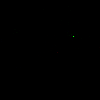

In [335]:
colorview(RGB, scaled_energy)